In [ ]:
library(tidyverse)
library(arrow)
library(cowplot)
library(yardstick)
library(scattermore)
library(tictoc)

In [3]:
direct_df <- fs::dir_ls("data/gwas/", glob = "*plink*zst") %>%
    map(
        ~read_tsv_arrow(.x, col_select = c("ID", "BETA", "SE", "P")) %>%
            mutate(phenotype_id = str_remove_all(.x, "data/gwas/plink.|.glm.linear.zst"))
    ) %>%
    bind_rows %>%
    mutate(P = -log10(P)) %>%
    rename(variant_id = ID, beta = BETA, std_error = SE, p_value = P) %>%
    select(phenotype_id, variant_id, beta, std_error, p_value)

direct_df %>% write_parquet("plot_data/direct_df.parquet")

direct_df %>% nrow
direct_df %>% head(2)

[1] 216500000

phenotype_id,variant_id,beta,std_error,p_value
<chr>,<chr>,<dbl>,<dbl>,<dbl>
phecode_008.5,1:761147,0.000239470,0.000295757,0.3786959
phecode_008.5,1:768448,0.000318601,0.000343877,0.4507637


In [5]:
merged_df <- bind_rows(
        read_tsv_arrow("data/igwas/phecodes.tsv.zst", col_select = c("phenotype_id", "variant_id", "p_value")) %>% 
            mutate(type = "Full phecode"),
        read_tsv_arrow("data/igwas/phecodes_inclusion_only.tsv.zst", col_select = c("phenotype_id", "variant_id", "p_value")) %>% 
            mutate(type = "Inclusion only"),
    ) %>%
    inner_join(direct_df, by = c("phenotype_id", "variant_id"), suffix = c("_indirect", "_direct")) %>%
    mutate(type = factor(type, levels = c("Full phecode", "Inclusion only")))

merged_df %>% write_parquet("plot_data/merged_pvalue_df.parquet")

merged_df %>% nrow
merged_df %>% head(2)

[1] 433000000

phenotype_id,variant_id,p_value_indirect,type,beta,std_error,p_value_direct
<chr>,<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
phecode_008,1:761147,0.83468914,Full phecode,0.001986460,0.00137368,0.8292837
phecode_008,1:768448,0.03205016,Full phecode,-0.000157467,0.00159881,0.0354844


In [7]:
p_value_rsq_df <- merged_df %>%
    group_by(type) %>%
    summarize(rsq = rsq_vec(p_value_direct, p_value_indirect)) %>%
    mutate(
        label = rsq %>%
            round(2) %>%
            str_c("R^2==", .)
    )

p_value_rsq_df %>% write_parquet("plot_data/pvalue_rsquared.parquet")

p_value_rsq_df

type,rsq,label
<fct>,<dbl>,<chr>
Full phecode,0.9358560,R^2==0.94
Inclusion only,0.9597152,R^2==0.96


# Load and plot

In [2]:
merged_df <- read_parquet("plot_data/merged_pvalue_df.parquet")
p_value_rsq_df <- read_parquet("plot_data/pvalue_rsquared.parquet")
fit_quality_df <- read_parquet("plot_data/phecode_r2.parquet") %>%
    pivot_longer(full:incl, names_to = "type", values_to = "rsq") %>%
    mutate(type = type %>% recode_factor(full = "Full phecode", incl = "Inclusion only"))

In [3]:
plot_df <- merged_df %>%
    inner_join(fit_quality_df, by = c("phenotype_id", "type")) %>%
    arrange(rsq)

952.747 sec elapsed


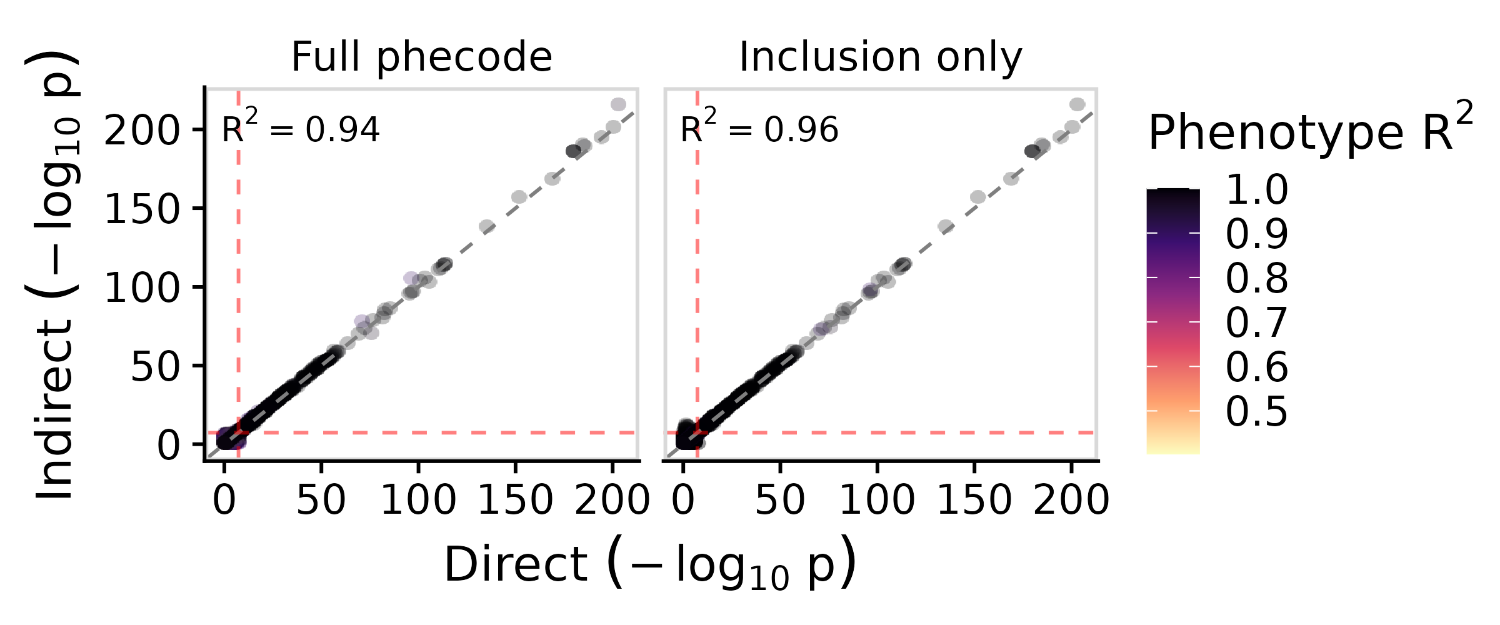

In [4]:
options(repr.plot.width = 6, repr.plot.height = 2.5, repr.plot.res = 250)

tic()

full_plot <- plot_df %>%
    ggplot(aes(x = p_value_direct, y = p_value_indirect, color = rsq)) +
    geom_scattermore(alpha = 0.25, pointsize = 10) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey50") +
    geom_vline(xintercept = -log10(5e-8), linetype = "dashed", color = "red", alpha = 0.5) +
    geom_hline(yintercept = -log10(5e-8), linetype = "dashed", color = "red", alpha = 0.5) +
    geom_text(
        data = p_value_rsq_df, 
        aes(x = -Inf, y = Inf, label = label, color = NULL),
        vjust = 1.5, hjust = -0.1, parse = T, size = 3.5
    ) +
    theme_cowplot() +
    panel_border() +
    theme(
        strip.background = element_blank()
    ) +
    facet_wrap(vars(type)) +
    # coord_equal(xlim = c(0, 50), ylim = c(0, 50)) +
    xlab(expression("Direct"~(-log[10]~p))) +
    ylab(expression("Indirect"~(-log[10]~p))) +
    scale_color_viridis_c(name = expression("Phenotype"~R^2), option = "magma", direction = -1)

save_plot("img/phecode_pvalues.png", full_plot, base_width = 6, base_height = 2.5, dpi = 400)

grid::grid.raster(png::readPNG("img/phecode_pvalues.png"))

toc()